In [82]:
import plenoptic as po
import torch
import numpy as np
# needed for the plotting/animating:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['animation.html'] = 'html5'
# use single-threaded ffmpeg for animation writer
plt.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams['animation.ffmpeg_args'] = ['-threads', '1']
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision
import einops

In [3]:
model = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights.IMAGENET1K_V1)
transform = torchvision.models.AlexNet_Weights.IMAGENET1K_V1.transforms()

In [4]:
class TorchVision(torch.nn.Module):
    def __init__(self, model, return_node: str, transform = None):
        super().__init__()
        self.transform = transform
        self.extractor = create_feature_extractor(model, return_nodes=[return_node])
        self.model = model
        self.return_node = return_node
    
    def forward(self, x):
        if self.transform is not None:
            x = self.transform(x)
        return self.extractor(x)[self.return_node]
    
    def plot_representation(
        self,
        data: torch.Tensor,
        ax = None,
        figsize = (15, 15),
        ylim = None,
        batch_idx = 0,
        title = None,
    ):
        # Select the batch index
        data = data[batch_idx]

        # Compute across channels spatal error
        spatial_error = torch.abs(data).mean(dim=0).detach().cpu().numpy()

        # Compute per-channel error
        error = torch.abs(data).mean(dim=(1, 2))  # Shape: (C,)
        sorted_idx = torch.argsort(error, descending=True)
        sorted_error = error[sorted_idx].detach().cpu().numpy()

        # Determine figure layout
        if ax is None:
            fig, axes = plt.subplots(2, 1, figsize=figsize, gridspec_kw={"height_ratios": [1, 1]})
        else:
            ax = po.tools.clean_up_axes(ax, False, ["top", "right", "bottom", "left"], ["x", "y"])
            gs = ax.get_subplotspec().subgridspec(2, 1, height_ratios=[3, 1])
            fig = ax.figure
            axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

        # Plot average error across channels
        po.imshow(
            ax=axes[0], image=spatial_error[None, None, ...], title="Average Error Across Channels", vrange="auto0"
        )
        # axes[0].set_title()

        # Plot channel error distribution
        x_pos = np.arange(20)
        axes[1].bar(x_pos, sorted_error[:20], color="C1", alpha=0.7)
        axes[1].set_xticks(x_pos)
        axes[1].set_xticklabels(sorted_idx[:20].tolist(), rotation=45)
        axes[1].set_xlabel("Channel")
        axes[1].set_ylabel("Absolute error")
        axes[1].set_title("Top 20 Channels Contributions to Error")

        if title is not None:
            fig.suptitle(title)

        return fig, axes

In [5]:
train_nodes, eval_nodes = get_graph_node_names(model)

In [6]:
eval_nodes[-10:]

['features.12',
 'avgpool',
 'flatten',
 'classifier.0',
 'classifier.1',
 'classifier.2',
 'classifier.3',
 'classifier.4',
 'classifier.5',
 'classifier.6']

In [8]:
mdl = TorchVision(model, 'features.12', transform)

In [9]:
mdl.to(0)
po.tools.remove_grad(mdl)
mdl.eval()
po.tools.validate.validate_model(mdl, device=0, image_shape=img.shape)

In [255]:
imagenet_categories = np.asarray(torchvision.models.AlexNet_Weights.IMAGENET1K_V1.meta['categories'])

In [256]:
cifar = torchvision.datasets.CIFAR10("/mnt/ceph/users/wbroderick/image_datasets/CIFAR10", download=False)

In [257]:
idx_to_class = {v: k for k, v in cifar.class_to_idx.items()}
img_idx = 1
img = torch.as_tensor(cifar.data[img_idx]).to(0)
img = img / torch.iinfo(img.dtype).max
img = einops.rearrange(img, "h w c -> 1 c h w")

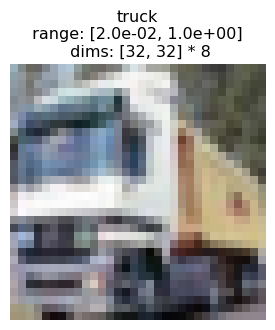

In [258]:
po.imshow(img, as_rgb=True, zoom=8, title=idx_to_class[cifar.targets[img_idx]]);

In [259]:
img_categories = torch.nn.functional.softmax(model(transform(img))).squeeze().cpu()

/tmp/ipykernel_3834416/379185416.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  img_categories = torch.nn.functional.softmax(model(transform(img))).squeeze().cpu()


<Axes: >

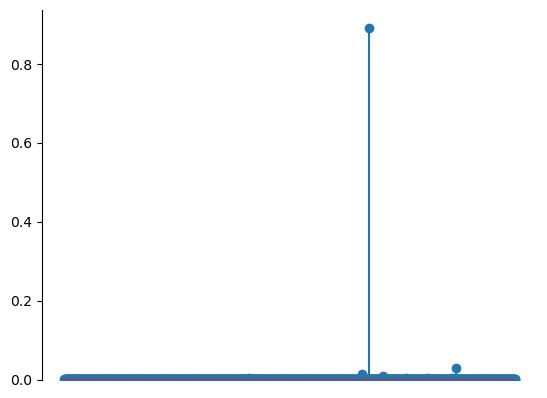

In [260]:
po.tools.clean_stem_plot(img_categories.cpu())

In [261]:
imagenet_categories[img_categories>.1]

array(['moving van'], dtype='<U30')

In [262]:
imagenet_categories[img_categories.argmax()]

'moving van'

In [263]:
metric = lambda x, y: torch.sqrt(torch.mean((mdl(x)-mdl(y))**2)+1e-20)

In [264]:
mad = po.synth.MADCompetition(img, metric, lambda x,y: po.metric.mse(x,y).mean(), "max", metric_tradeoff_lambda=1e9)
mad.setup(.01)

In [265]:
mad.synthesize(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

/mnt/home/wbroderick/plenoptic/src/plenoptic/synthesize/mad_competition.py:314: UserWarning: Loss has converged, stopping synthesis
  warnings.warn("Loss has converged, stopping synthesis")


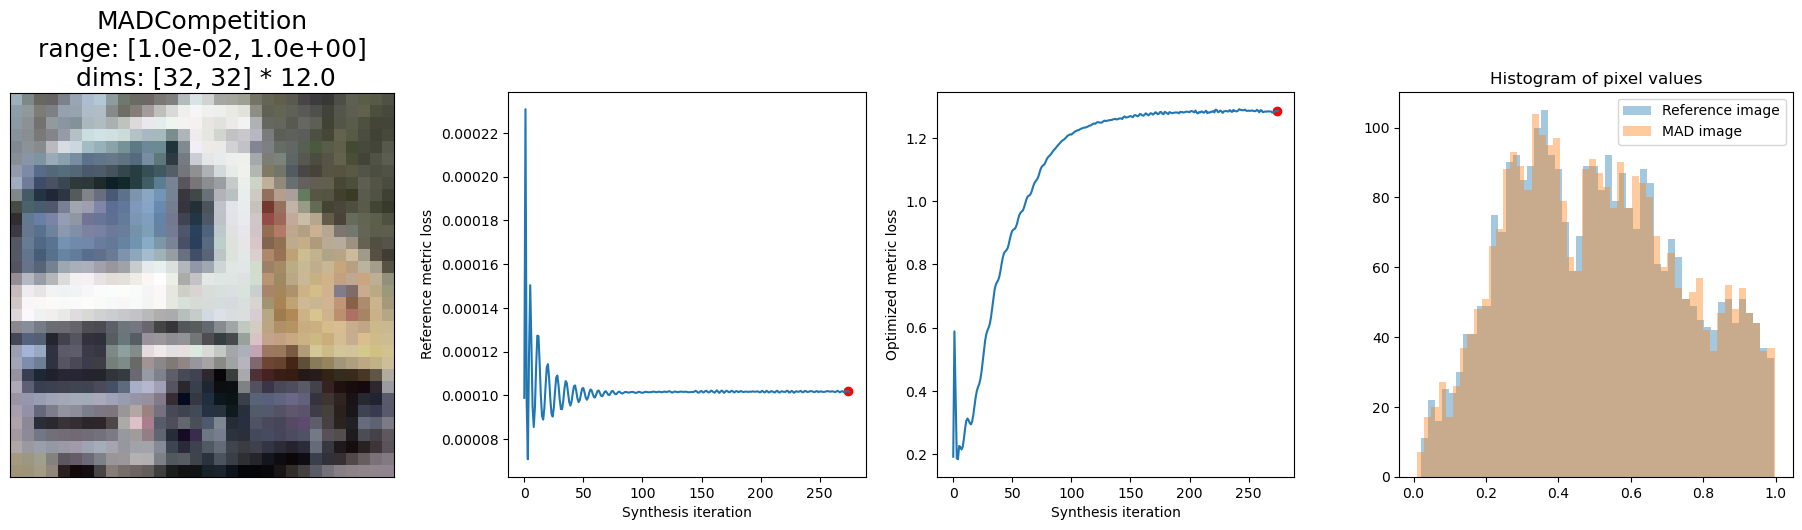

In [266]:
po.synth.mad_competition.plot_synthesis_status(mad);

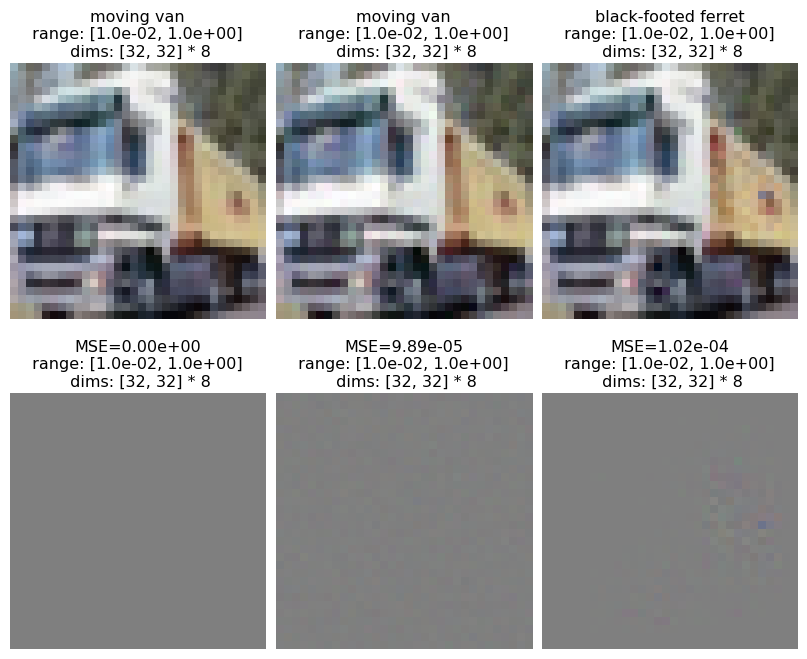

In [267]:
imgs = [img, mad.initial_image, mad.mad_image]
mse = [po.metric.mse(img, i) for i in imgs]
titles = [imagenet_categories[model(transform(i)).argmax()] for i in imgs]
diffs = [(i+1)/2 for i in [img-img, mad.initial_image-img, mad.mad_image-img]]
titles.extend([f"MSE={m.mean().item():.2e}" for m in mse])
imgs.extend(diffs)
po.imshow(imgs, as_rgb=True, zoom=8, title=titles, col_wrap=3, vrange='auto1');

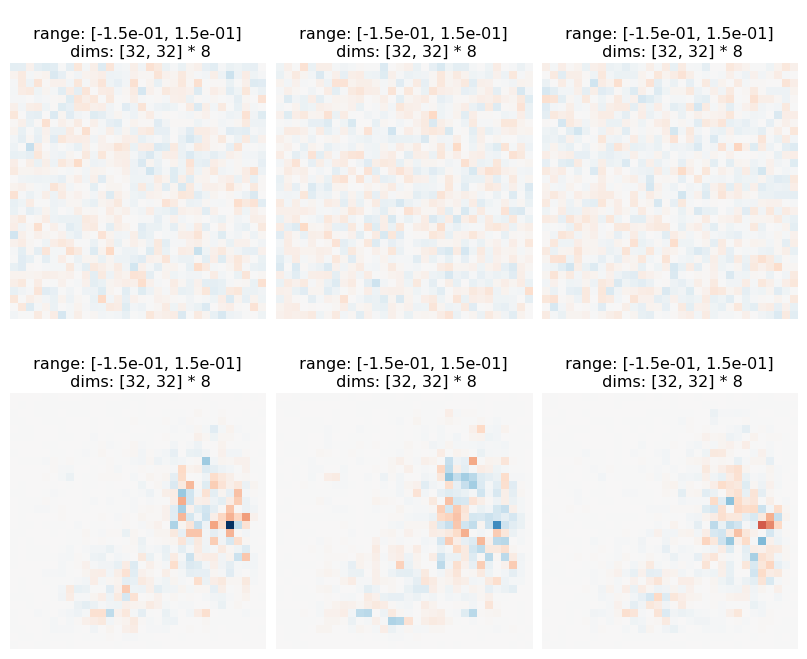

In [268]:
channelwise_diffs = [mad.initial_image-img, mad.mad_image-img]
po.imshow(channelwise_diffs, col_wrap=3, zoom=8, vrange='auto0');

/tmp/ipykernel_3834416/1585761780.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  img_categories = torch.nn.functional.softmax(model(transform(img))).squeeze().cpu().detach()


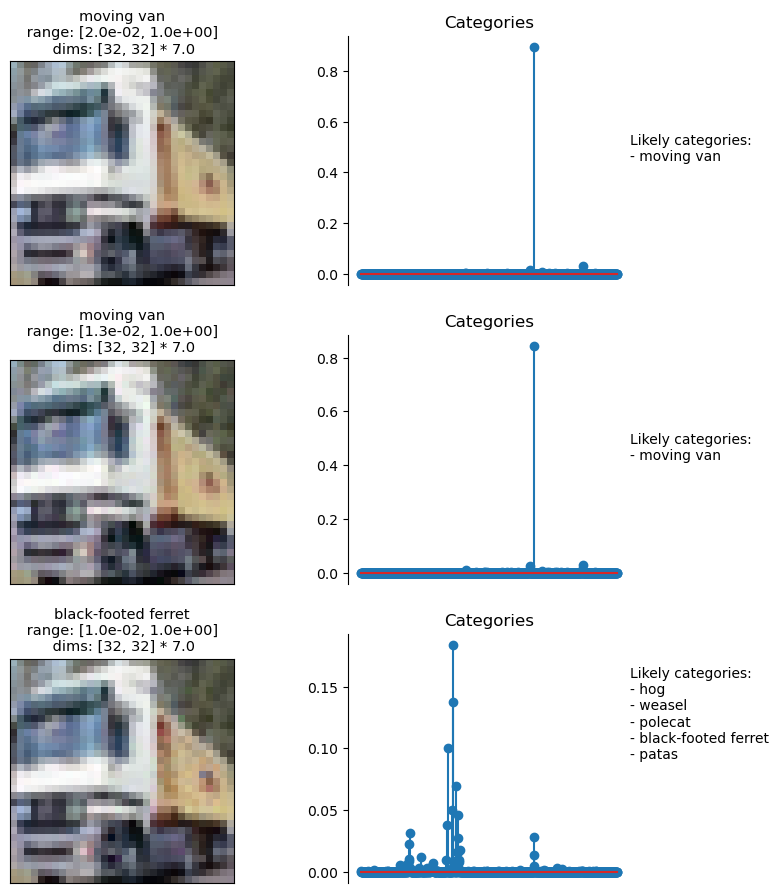

In [302]:
fig, axes = plt.subplots(3, 2, figsize=(8, 11))
for i, img in enumerate([mad.image, mad.initial_image, mad.mad_image]):
    po.imshow(img, ax=axes[i, 0], as_rgb=True, title=titles[i])
    img_categories = torch.nn.functional.softmax(model(transform(img))).squeeze().cpu().detach()
    likely_cats = '\n- '.join(list(imagenet_categories[img_categories>.05]))
    po.tools.clean_stem_plot(img_categories, ax=axes[i,1], ylim=False)
    axes[i,1].set_title("Categories")
    axes[i,0].xaxis.set_visible(False)
    axes[i,0].yaxis.set_visible(False)
    axes[i,1].text(1, .5, f"Likely categories:\n- {likely_cats}", transform=axes[i,1].transAxes)